# Alternating Least Squares (ALS) and Maximum Likelihood Estimation (MLE)

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict, deque

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load data

In [5]:
ml_ratings_df = pd.read_csv(os.path.join("data", "movielens_small", "ratings.csv")).rename(columns={'userId': 'user_id', 'movieId': 'item_id'})
ml_movies_df = pd.read_csv(os.path.join("data", "movielens_small", "movies.csv")).rename(columns={'movieId': 'item_id'})
ml_df = pd.merge(ml_ratings_df, ml_movies_df, on='item_id')

# Filter the data to reduce the number of movies
seed = 6789
rng = np.random.RandomState(seed=seed)
left_ids = rng.choice(ml_movies_df['item_id'], size=90, replace=False)
left_ids = list(set(left_ids).union(set([1, 318, 1193, 1208, 1214, 1721, 2959, 3578, 4306, 109487])))

ml_ratings_df = ml_ratings_df.loc[ml_ratings_df['item_id'].isin(left_ids)]
ml_movies_df = ml_movies_df.loc[ml_movies_df['item_id'].isin(left_ids)]
ml_df = ml_df.loc[ml_df['item_id'].isin(left_ids)]

display(ml_movies_df.head(10))

print("Number of interactions left: {}".format(len(ml_ratings_df)))

,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
143,171,Jeffrey (1995),Comedy|Drama
194,228,Destiny Turns on the Radio (1995),Comedy
199,233,Exotica (1994),Drama
230,267,Major Payne (1995),Comedy
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
313,355,"Flintstones, The (1994)",Children|Comedy|Fantasy
379,435,Coneheads (1993),Comedy|Sci-Fi
419,481,Kalifornia (1993),Drama|Thriller
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller


Number of interactions left: 2761


## Shift item ids and user ids so that they are consecutive

In [6]:
interactions_df = ml_ratings_df.copy()

unique_item_ids = interactions_df['item_id'].unique()
item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
unique_user_ids = interactions_df['user_id'].unique()
user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

interactions_df['item_id'] = interactions_df['item_id'].map(item_id_mapping)
interactions_df['user_id'] = interactions_df['user_id'].map(user_id_mapping)

display(interactions_df.head(10))

,user_id,item_id,rating,timestamp
0,0,0,4.0,964982703
42,0,1,3.0,964984086
72,0,2,4.0,964983250
75,0,3,4.0,964981855
97,0,4,4.0,964980985
192,0,5,5.0,964983282
216,0,6,4.0,964981725
219,0,7,5.0,964980668
232,1,8,3.0,1445714835
235,1,7,4.0,1445714885


## Get the number of items and users

In [7]:
n_items = np.max(interactions_df['item_id']) + 1
n_users = np.max(interactions_df['user_id']) + 1

print("n_items={}\nn_users={}".format(n_items, n_users))

n_items=100
n_users=555


## Get the user-item interaction matrix

In [8]:
# mapping to int is necessary because of how iterrows works
r = np.zeros(shape=(n_users, n_items))
for idx, interaction in interactions_df.iterrows():
    r[int(interaction['user_id'])][int(interaction['item_id'])] = 1
    
print(r)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


## Least squares

**Task 1.** Write a method perform_least_squares for performing the matrix calculation of the linear model coefficients minimizing the square loss for a given 2D dataset (where the first column is x - the explanatory variable, the second column is y - the target variable). The method should return a tuple of fitted theta_0 and theta_1. To fit the bias term (theta_0) you have to concatenate 1 to every input vector, e.g. $[0.2]$ -> $[1, 0.2]$.

The interface of the method should be as follows:
    
    perform_least_squares(data)
    
Compare your solution to the optimal one found by sklearn.linear_model.LinearRegression.
    
Plot the data (as scatterplot) and the fit (as lineplot) on a single seaborn chart.

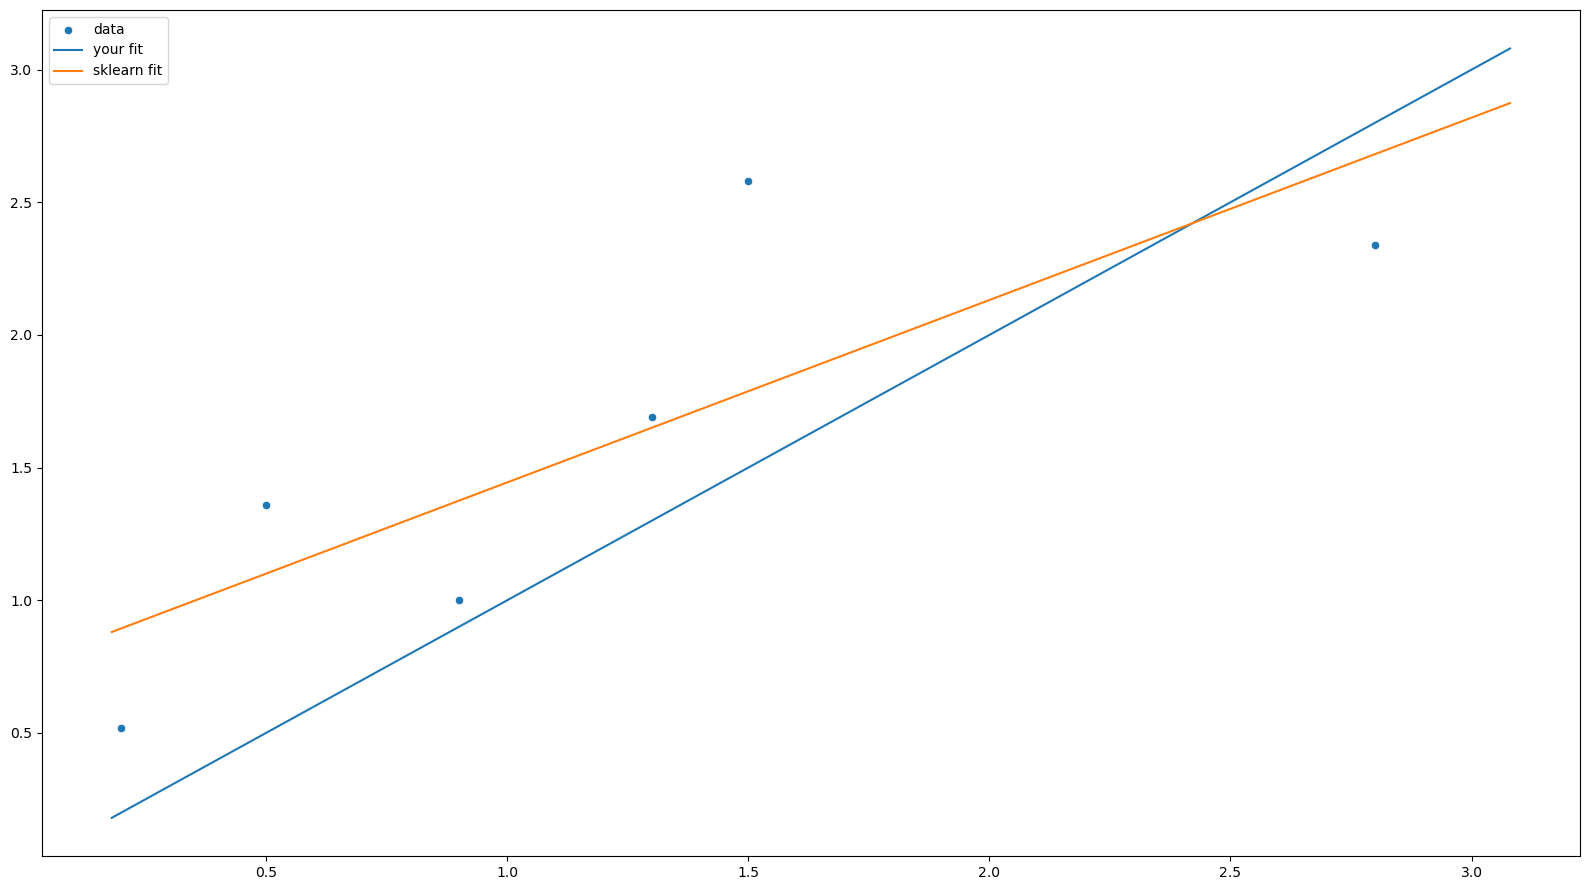

In [9]:
data = np.array([
    [0.2, 0.52],
    [0.5, 1.36],
    [0.9, 1.00],
    [1.3, 1.69],
    [1.5, 2.58],
    [2.8, 2.34]
])


def perform_least_squares(data):
    x, y = data[:, 0], data[:, 1]
    
    xy = []
    for i in range(len(x)):
        xy.append(x[i] * y[i])
    x_sqrt = [i**2 for i in x]
    n  = len(x)
    theta_0 = (n*sum(xy) - sum(x)*sum(y)) / (n*sum(x_sqrt) - sum(x)**2)
    theta_1 = (sum(y) - theta_0*sum(x))/n
    
    return theta_1, theta_0


theta_0, theta_1 = perform_least_squares(data)

min_x = min(data[:, 0]) * 0.9
max_x = max(data[:, 0]) * 1.1
x = np.linspace(min_x, max_x, 100)
y = theta_1 * x + theta_0

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(data[:, 0].reshape(-1, 1), data[:, 1].flatten())
y_lin = reg.predict(x.reshape(-1, 1))

fig = plt.figure(tight_layout=True)
fig.set_size_inches(16, 9)
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(x=data[:, 0], y=data[:, 1], ax=ax1, label="data")
sns.lineplot(x=x, y=y, ax=ax1, label="your fit")
sns.lineplot(x=x, y=y_lin, ax=ax1, label="sklearn fit")

plt.show()

## Alternating Least Squares (ALS)

Generate negative interactions - copy your code from notebook 8.

In [10]:
n_neg_per_pos = 5
interactions_pos_neg_df = interactions_df[['user_id', 'item_id']].copy()

# Indicate positive interactions

interactions_pos_neg_df['interacted'] = 1

# Generate negative interactions

negative_interactions = []

i = 0
while i < n_neg_per_pos * len(interactions_df):
    sample_size = 1000
    user_ids = rng.choice(np.arange(n_users), size=sample_size)
    item_ids = rng.choice(np.arange(n_items), size=sample_size)

    j = 0
    while j < sample_size and i < n_neg_per_pos * len(interactions_df):
        if r[user_ids[j]][item_ids[j]] == 0:
            negative_interactions.append([user_ids[j], item_ids[j], 0])
            i += 1
        j += 1
        
interactions_pos_neg_df = pd.concat(
    [interactions_pos_neg_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])

# display(interactions_pos_neg_df)


**Task 2.** From interactions_pos_neg_df create two dictionaries:
- interactions_pos_neg_user_dict where keys are user ids and values are lists of item ids the user has interacted with,
- interactions_pos_neg_item_dict where keys are item ids and values are lists of user ids who interacted with the item.

In [11]:

interactions_pos_neg_user_dict = {}
for i in range(r.shape[0]):
    interactions_pos_neg_user_dict[i] = []
for index, row in interactions_pos_neg_df.iterrows():
    user_id = row["user_id"]
    item_id = row["item_id"]
    interacted = row["interacted"]
    if True:
        interactions_pos_neg_user_dict[user_id].append(item_id)

interactions_pos_neg_item_dict = {}
# for i in range(r.shape[1]):
#     interactions_pos_neg_item_dict[i] = r[:,i].nonzero()[0].tolist()
for i in range(r.shape[1]):
    interactions_pos_neg_item_dict[i] = []
for index, row in interactions_pos_neg_df.iterrows():
    user_id = row["user_id"]
    item_id = row["item_id"]
    interacted = row["interacted"]
    if True:
        interactions_pos_neg_item_dict[item_id].append(user_id)


print("Interactions of user_id=0")
print(interactions_pos_neg_user_dict[0])
display(interactions_pos_neg_df.loc[interactions_pos_neg_df['user_id'] == 0])
print()
print("Interactions of user_id=1")
print(interactions_pos_neg_user_dict[1])
display(interactions_pos_neg_df.loc[interactions_pos_neg_df['user_id'] == 1])
print()
print("Interactions of item_id=0")
print(interactions_pos_neg_item_dict[0])
display(interactions_pos_neg_df.loc[interactions_pos_neg_df['item_id'] == 0])
print()
print("Interactions of item_id=1")
print(interactions_pos_neg_item_dict[1])
display(interactions_pos_neg_df.loc[interactions_pos_neg_df['item_id'] == 1])

Interactions of user_id=0
[0, 1, 2, 3, 4, 5, 6, 7]


,user_id,item_id,interacted
0,0,0,1
42,0,1,1
72,0,2,1
75,0,3,1
97,0,4,1
192,0,5,1
216,0,6,1
219,0,7,1
190,0,41,0
384,0,55,0



Interactions of user_id=1
[7, 8, 9]


,user_id,item_id,interacted
232,1,8,1
235,1,7,1
255,1,9,1
1033,1,34,0
2212,1,75,0
2641,1,32,0
3248,1,89,0
3268,1,85,0
3501,1,93,0
5251,1,24,0



Interactions of item_id=0
[0, 3, 5, 12, 14, 15, 16, 18, 23, 27, 28, 29, 35, 38, 39, 40, 41, 45, 49, 51, 57, 58, 60, 62, 65, 67, 70, 72, 76, 79, 81, 82, 83, 84, 87, 89, 94, 98, 103, 109, 111, 114, 119, 121, 123, 124, 126, 128, 129, 132, 133, 137, 139, 141, 142, 145, 146, 147, 152, 153, 155, 157, 163, 164, 165, 168, 171, 172, 176, 177, 184, 185, 186, 190, 195, 196, 198, 199, 200, 201, 204, 207, 210, 213, 214, 215, 220, 221, 226, 228, 231, 232, 240, 241, 243, 246, 247, 250, 251, 252, 253, 254, 256, 257, 258, 259, 264, 266, 267, 268, 269, 274, 280, 283, 290, 296, 297, 301, 303, 305, 307, 309, 310, 312, 314, 320, 322, 325, 329, 331, 336, 339, 343, 344, 349, 351, 352, 353, 356, 360, 362, 366, 367, 369, 377, 378, 380, 386, 388, 397, 399, 401, 403, 407, 412, 415, 417, 420, 422, 424, 430, 431, 432, 433, 436, 438, 439, 441, 444, 445, 448, 450, 452, 459, 463, 466, 471, 474, 478, 480, 481, 484, 485, 487, 488, 493, 496, 499, 504, 508, 509, 510, 511, 516, 517, 519, 520, 523, 524, 528, 531, 534, 540

,user_id,item_id,interacted
0,0,0,1
516,3,0,1
874,5,0,1
1434,12,0,1
1667,14,0,1
...,...,...,...
13310,10,0,0
13337,295,0,0
13459,328,0,0
13663,330,0,0



Interactions of item_id=1
[0, 4, 5, 8, 12, 14, 15, 18, 21, 23, 24, 25, 27, 28, 30, 37, 39, 40, 43, 51, 52, 53, 57, 58, 60, 62, 65, 66, 72, 76, 79, 82, 83, 87, 95, 100, 103, 106, 107, 108, 110, 111, 112, 118, 122, 124, 126, 128, 129, 132, 135, 136, 137, 139, 146, 150, 157, 160, 162, 163, 164, 165, 168, 172, 173, 182, 183, 184, 185, 186, 190, 194, 196, 199, 200, 201, 202, 204, 207, 211, 213, 214, 216, 220, 221, 224, 225, 228, 232, 233, 241, 242, 246, 247, 251, 253, 254, 256, 258, 264, 268, 274, 277, 278, 280, 281, 283, 288, 289, 290, 292, 295, 296, 303, 305, 308, 310, 313, 320, 326, 329, 331, 333, 336, 340, 345, 347, 351, 352, 356, 357, 358, 360, 362, 367, 370, 380, 385, 388, 391, 394, 397, 399, 402, 403, 409, 410, 412, 415, 416, 417, 420, 425, 426, 429, 431, 436, 439, 441, 443, 444, 445, 446, 449, 452, 455, 460, 470, 474, 477, 478, 480, 483, 485, 488, 496, 501, 504, 508, 509, 510, 515, 517, 520, 522, 523, 524, 533, 534, 536, 537, 538, 539, 541, 543, 544, 546, 549, 550, 551, 552, 554]


,user_id,item_id,interacted
42,0,1,1
839,4,1,1
892,5,1,1
1291,8,1,1
1451,12,1,1
...,...,...,...
12981,177,1,0
13268,500,1,0
13287,428,1,0
13351,355,1,0


Initialize user and item embeddings of size embedding_dim - use your code from notebook 8.

In [12]:
embedding_dim = 2
rng = np.random.RandomState(seed=seed)

user_repr_matrix = rng.normal(0, 1, size=(r.shape[0], embedding_dim))
item_repr_matrix = rng.normal(0, 1, size=(r.shape[1], embedding_dim))

print(user_repr_matrix)
print()
print(item_repr_matrix)

[[ 1.55384326  0.28995776]
 [-0.46923701  1.80495031]
 [-0.49037341 -0.15121921]
 ...
 [-0.43528032 -0.37379991]
 [-0.00383725  3.1814677 ]
 [-0.29370816  0.21336489]]

[[-0.45193749  1.33442799]
 [ 0.05942583 -0.77180582]
 [-1.57604756  1.31985401]
 [ 0.72457803  1.12398941]
 [-2.84383505  0.68639228]
 [ 0.90611796  0.24346264]
 [ 0.37150664  0.27393443]
 [ 1.1545844  -0.3169259 ]
 [ 1.70288559  0.44635168]
 [ 1.5483352   0.116946  ]
 [-0.94024256 -2.22230544]
 [ 1.94948623  0.43964253]
 [ 1.67700131  1.56280059]
 [ 1.18086166  0.34140066]
 [-0.12597979 -1.45195165]
 [-0.26048603 -0.12535205]
 [-1.25733817 -1.58234288]
 [ 0.88991681 -1.67880596]
 [-1.5415643   0.83596422]
 [-0.48575124  1.2336953 ]
 [ 0.664869    0.38821939]
 [-0.38497652 -0.02550559]
 [-0.1600649   0.19916925]
 [-0.52415476 -1.52751961]
 [-0.51168743  2.71411465]
 [ 0.53548438  0.99930379]
 [ 1.10562831 -0.61797124]
 [ 0.30645891  0.42944917]
 [-0.57810398  0.53526759]
 [-1.14830141  0.57178189]
 [-0.81171889 -0.0100

**Task 3.** Write the perform_mf_als_step method which takes item/user representations interacting_reprs for items the user has interacted with or for users who interacted with a given item (a 2D matrix where each row corresponds to an item representation/embedding), interaction values r_ui which is a 1D matrix of binary values to be predicted (the value from the interaction matrix - interactions_pos_neg_df), regularization constant reg_l, and performs a single step of Alternating Least Squares for matrix factorization as described in Koren, Bell, Volinksy "Matrix Factorization Techniques for Recommender Systems". You can use sklearn.linear_model.Ridge for that (x should be interacting_reprs, y should be r_ui and the result will be the new representation for the given user/item, you also have to disable fitting the intercept/bias in the model by setting fit_intercept=False). The method should return the new representation.

In [13]:
from sklearn.linear_model import Ridge

def perform_mf_als_step(interacting_reprs, r_ui, reg_l):
    
    model = Ridge(alpha=reg_l,fit_intercept=False)
    model.fit(interacting_reprs,r_ui)
    
    return model.coef_


# Test

interacting_item_repr_matrix = np.array([[0.75, 0.15], [-0.12, 0.32], [0.44, -0.95]])
r_ui = np.array([1, 0, 0])
reg_l = 0.1
new_user_repr = perform_mf_als_step(interacting_item_repr_matrix, r_ui, reg_l)
print(new_user_repr)

[0.84705948 0.01930615 0.02973395]


**Task 4.** Write the perform_mf_als_epoch method which takes interactions_df, user_repr_matrix, item_repr_matrix, regularization constant reg_l as input, and then:
- iterate over all users of interactions_df, perform perform_mf_als_step for every user (use the interactions_pos_neg_user_dict dictionary to get representations (rows in item_repr_matrix) and interactions ("interacted" column from interactions_df) for the items the the user has interacted with), update the appropriate user representation in the user_repr_matrix,
- iterate over all items of interactions_df, perform perform_mf_als_step for every item (use the interactions_pos_neg_item_dict dictionary to get representations (rows in user_repr_matrix) and interactions ("interacted" column from interactions_df) for the users who interacted with the given item), update the appropriate item representation in the item_repr_matrix,
- return updated user_repr_matrix, item_repr_matrix.

To obtain consistent results run the cell creating base user and item representations again before running this cell.

In [14]:

def perform_mf_als_epoch(interactions_df, user_repr_matrix, item_repr_matrix, reg_l):
    
    new_user_repr_matrix = []
    new_item_repr_matrix = []
    
    for user_id in interactions_df["user_id"].unique():
        indices = np.array(interactions_pos_neg_user_dict[user_id])
        interacting_reprs = item_repr_matrix[indices,:]
        interactions = interactions_df[(interactions_df["user_id"]==user_id) &
                                        (interactions_df["item_id"].isin(indices))]["interacted"].tolist()
        new_user_repr_matrix.append(perform_mf_als_step(interacting_reprs,interactions,reg_l))
    new_user_repr_matrix = np.asarray(new_user_repr_matrix)
    
    for item_id in interactions_df["item_id"].unique():
        indices = np.array(interactions_pos_neg_item_dict[item_id])
        interacting_reprs = new_user_repr_matrix[indices,:]
        interactions = interactions_df[(interactions_df["item_id"]==item_id) &
                                        (interactions_df["user_id"].isin(indices))]["interacted"].tolist()
        new_item_repr_matrix.append(perform_mf_als_step(interacting_reprs,interactions,reg_l))
    new_item_repr_matrix = np.asarray(new_item_repr_matrix)
    
    return new_user_repr_matrix, new_item_repr_matrix



# Test

user_repr_matrix, item_repr_matrix \
    = perform_mf_als_epoch(interactions_pos_neg_df, user_repr_matrix, item_repr_matrix, reg_l)

print(user_repr_matrix)
print()
print(item_repr_matrix)

[[ 7.95499783e+01 -1.53493056e+00  1.43592019e-01]
 [-7.95174282e+01 -8.26729609e-01 -1.43533264e-01]
 [-1.08634609e+02 -1.11027291e+01 -1.96091352e-01]
 [ 2.50372086e+02  8.08964343e+00  4.51935174e-01]
 [ 1.78524062e+02  8.11202983e+00  3.22245600e-01]
 [ 1.54852169e+02  9.25473103e+00  2.79516551e-01]
 [ 3.34207725e+02  1.52257951e+01  6.03263042e-01]
 [ 2.70421060e+02  1.33456499e+01  4.88124657e-01]
 [ 3.74343381e+02  1.73076361e+01  6.75710075e-01]
 [-5.77322619e+01 -2.42749255e+00 -1.04209859e-01]
 [-3.91838508e+02 -1.34028493e+01 -7.07289725e-01]
 [-4.67660770e+01  4.65899397e+00 -8.44153014e-02]
 [ 1.11868438e+02  8.31989985e+00  2.01928589e-01]
 [-1.24296985e+02 -8.76182199e+00 -2.24362788e-01]
 [-1.35831707e+02 -6.90806151e+00 -2.45183586e-01]
 [ 1.61003692e+02  6.10769366e+00  2.90620382e-01]
 [ 1.47949317e+02  7.41870400e+00  2.67056530e-01]
 [ 1.32246595e+02 -8.84710777e-05  2.38712266e-01]
 [ 1.38148753e+02  9.15583949e+00  2.49365980e-01]
 [-1.32888344e+01 -2.63336853e+

**Task 5.** Write the perform_mf_als_training method which takes interactions_df, user_repr_matrix, item_repr_matrix, regularization constant reg_l, epsilon as input and performs the following steps until the loss change between epochs is smaller than epsilon for three consecutive epochs:
- perform perform_mf_als_epoch, 
- calculate the loss for the user and item representations returned by perform_mf_als_epoch using the formula from the Koren, Bell, Volinksy "Matrix Factorization Techniques for Recommender Systems" paper.
Finally return a tuple containing user_repr_matrix, item_repr_matrix and the final loss.

To obtain consistent results run the cell creating base user and item representations and task 4 cell again before running this cell.

In [15]:
from livelossplot import PlotLosses

def perform_mf_als_training(interactions_df, user_repr_matrix, item_repr_matrix, reg_l, epsilon):
    liveloss = PlotLosses()
    
    epoch = 0
    prev_loss = 0
    total_loss = 0
    
#     user_repr_matrix, item_repr_matrix = \
#         perform_mf_als_epoch(interactions_df, user_repr_matrix, item_repr_matrix, reg_l)
    
#     e_ui = r_ui - np.dot(user_repr,item_repr)
#     item_repr = item_repr + lr * (e_ui * user_repr - reg_l * item_repr)
#     user_repr = user_repr + lr * (e_ui * item_repr - reg_l * user_repr)
#     loss = e_ui**2

        # Save and print epoch losses (this should be at the end of the loop over epochs)

        training_last_avg_loss = total_loss / len(interactions_df)

        if epoch >= 3: # A bound on epoch prevents showing extremely high losses in the first epochs
            logs = {'loss': training_last_avg_loss}
            liveloss.update(logs)
            liveloss.send()
        epoch += 1

    return user_repr_matrix, item_repr_matrix, training_last_avg_loss

# Test

epsilon = 0.01
user_repr_matrix, item_repr_matrix, training_last_avg_loss \
    = perform_mf_als_training(interactions_pos_neg_df, user_repr_matrix, item_repr_matrix, reg_l, epsilon)

print(user_repr_matrix)
print()
print(item_repr_matrix)
print()
print(training_last_avg_loss)

IndentationError: unexpected indent (3192385467.py, line 20)

### Plot movie representations

Remember that they don't have to be good as only two dimensions have been used. But still try to find if you can assign any meaning to those dimensions based on your knowledge about plotted movies. You can open the image in new tab and enlarge.

In [ ]:
fig = plt.figure(tight_layout=True)
fig.set_size_inches(64, 36)
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(x=item_repr_matrix[:, 0], y=item_repr_matrix[:, 1], ax=ax1, color='red')
sns.scatterplot(x=user_repr_matrix[:, 0], y=user_repr_matrix[:, 1], ax=ax1, color='blue')

for i in range(len(item_repr_matrix)):
    title = ml_movies_df.loc[ml_movies_df['item_id'] == item_id_reverse_mapping[i], 'title'].iloc[0]
    plt.text(x=item_repr_matrix[i, 0] + 1 / 500, y=item_repr_matrix[i, 1] + 1 / 500, s=title, 
             fontdict=dict(color='red', size=8))
    
for i in range(len(user_repr_matrix)):
    plt.text(x=user_repr_matrix[i, 0] + 1 / 500, y=user_repr_matrix[i, 1] + 1 / 500, s=i, 
             fontdict=dict(color='blue', size=8))

plt.show()

## Maximum Likelihood Estimation for binary data

Generate the true logistic model and random data from it.

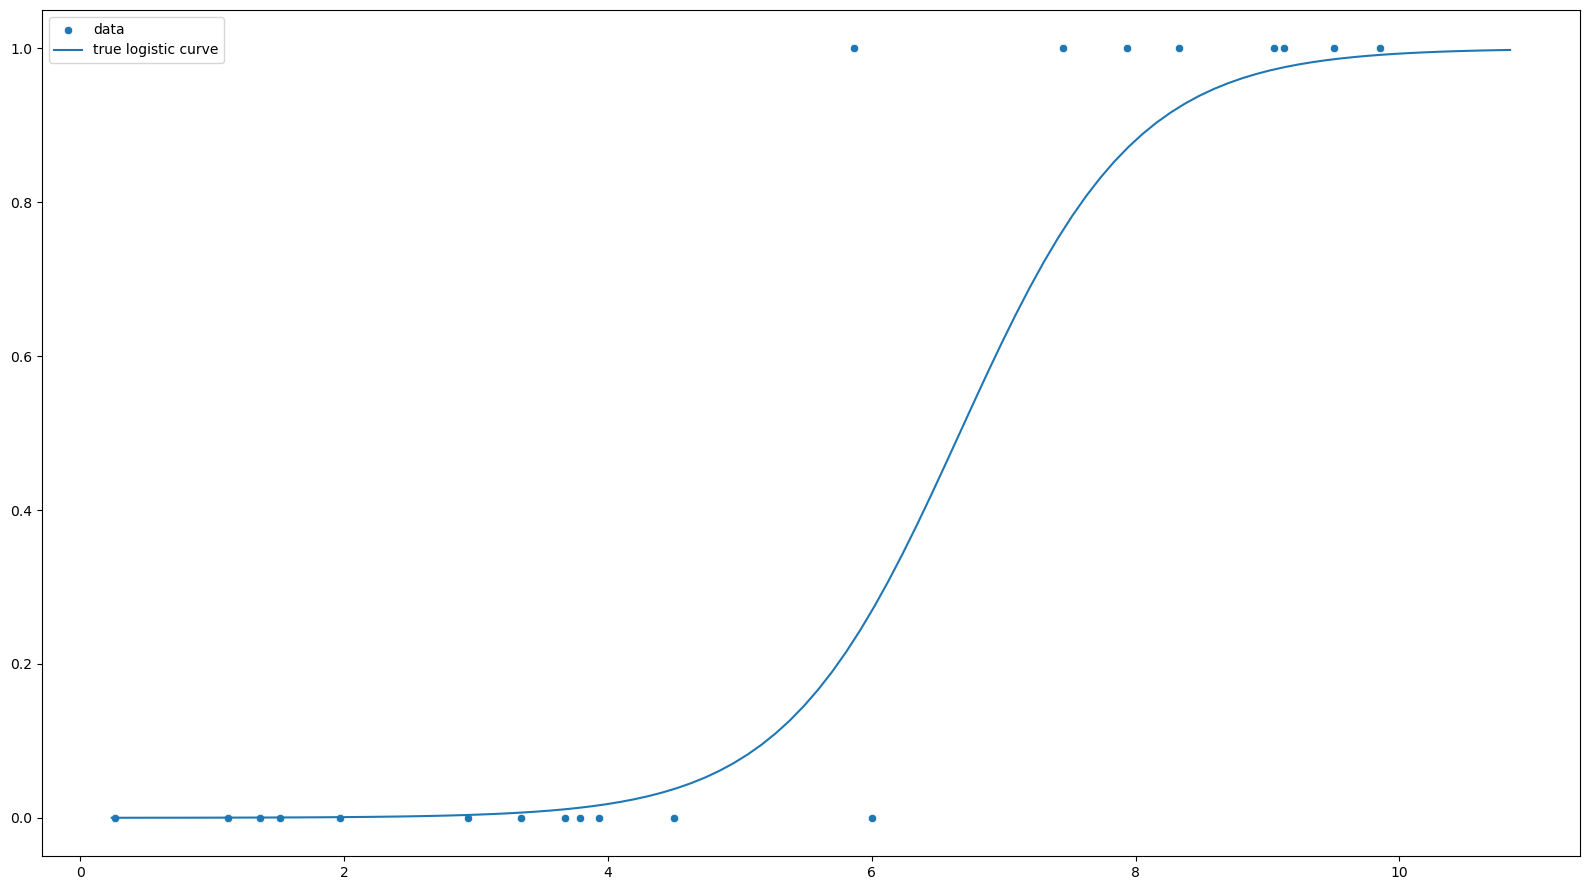

In [16]:
def log_curve(x, theta_0, theta_1):
    return 1 / (1 + np.exp(-theta_0 - theta_1 * x))

real_theta_0 = -10
real_theta_1 = 1.5

data_x = rng.uniform(0, 10, size=20)
p = log_curve(data_x, real_theta_0, real_theta_1)
data_y = rng.binomial(1, p)

min_x = min(data_x) * 0.9
max_x = max(data_x) * 1.1
x_grid = np.linspace(min_x, max_x, 100)
y_log_curve = log_curve(x_grid, real_theta_0, real_theta_1)

fig = plt.figure(tight_layout=True)
fig.set_size_inches(16, 9)
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(x=data_x, y=data_y, ax=ax1, label="data")
sns.lineplot(x=x_grid, y=y_log_curve, ax=ax1, label="true logistic curve")

plt.show()

**Task 6.** Code a loss function which returns the negative likelihood of observing a given dataset (data_x, data_y) given that the true model is a logistic curve with parameters theta_0, theta_1:
$$P(y = 1) = \frac{1}{1 + e^{-\theta_0 - \theta_1 * x}}$$

In [44]:
def loss_mle(params):
    theta_0, theta_1 = params['theta_0'], params['theta_1']
    ########################
    likelihood = 1
    for x,y in zip(data_x,data_y):
        if y==1:
            likelihood *= 1/(1+np.exp(-theta_0-theta_1*x))
        else:
            likelihood *= 1-(1/(1+np.exp(-theta_0-theta_1*x)))
    ########################
    return -likelihood

Use hyperopt to minimize the loss defined in the previous task on data_x, data_y. Plot the data, the true model and the MLE fit on one seaborn chart. How does it compare to the MSE fit in the next cell? Which one looks better? Experiment with different datasets.

In [45]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

space = {"theta_0": hp.uniform("theta_0", -50, 50),
         "theta_1": hp.loguniform("theta_1", np.log(0.01), np.log(100.0))}

succeded = False
n_tries = 3
t = 0
best_mle_param_set = {'theta_0': None, 'theta_1': None}
while not succeded and t < n_tries:
    try:
        trials = Trials()
        best_mle_param_set = fmin(loss_mle, space=space, algo=tpe.suggest, max_evals=100, show_progressbar=True, trials=trials)
        succeded = True
    except:
        t += 1
        traceback.print_exc()

# Best params

print("theta_0 = {}".format(best_mle_param_set['theta_0']))
print("theta_1 = {}".format(best_mle_param_set['theta_1']))

100%|█████████████████████████| 100/100 [00:00<00:00, 245.80trial/s, best loss: -18.997117207844706]
theta_0 = -48.74804324869352
theta_1 = 9.416861097612527


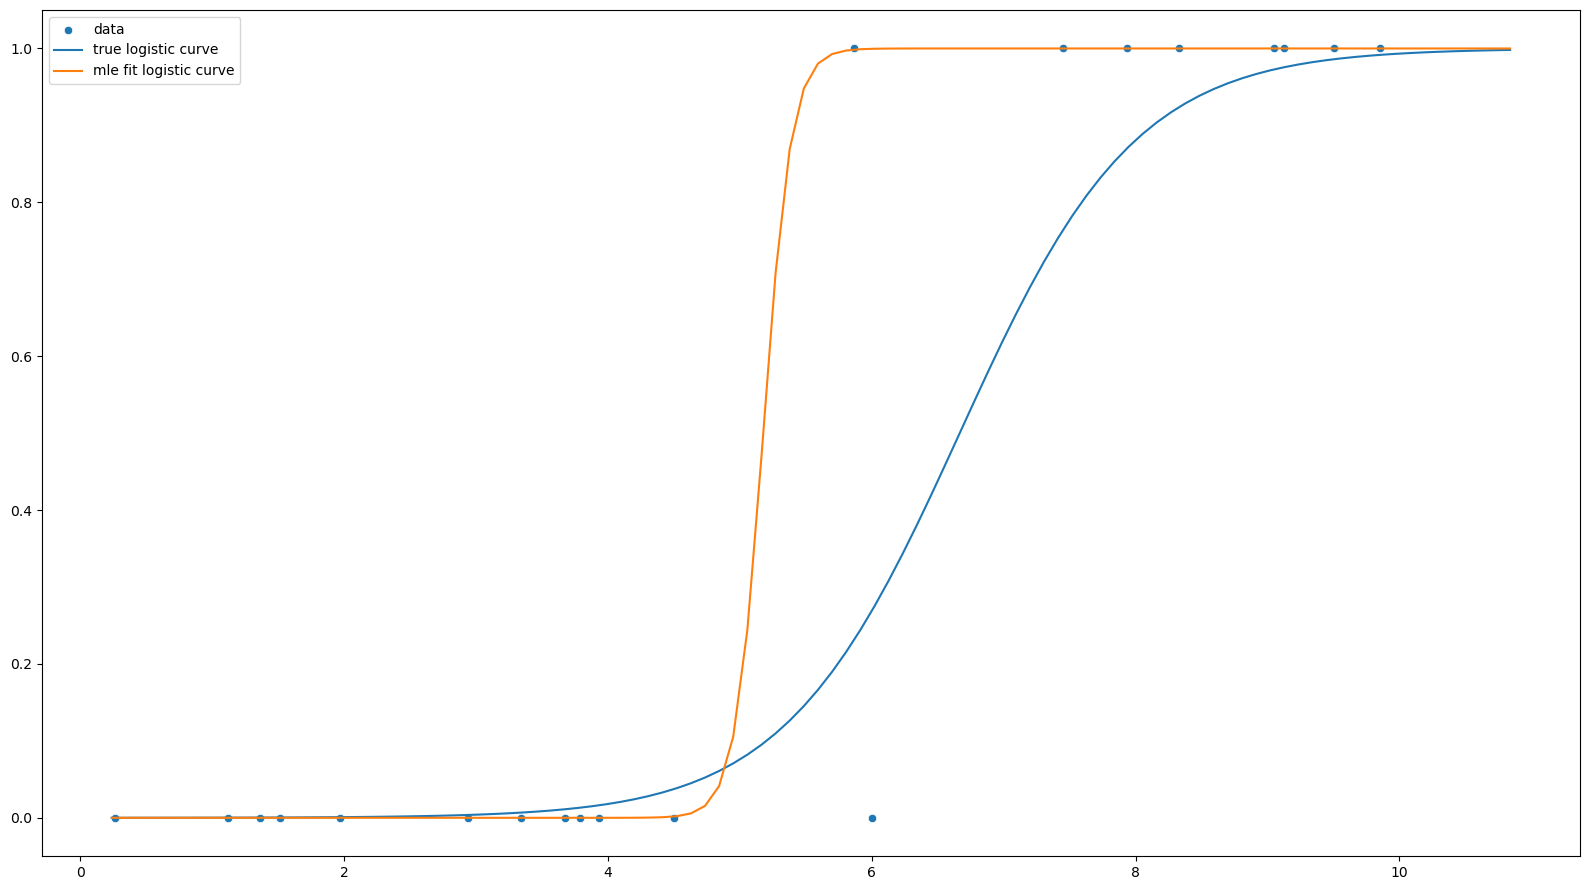

In [46]:
y_log_curve_mle_fit = log_curve(x_grid, best_mle_param_set['theta_0'], best_mle_param_set['theta_1'])

fig = plt.figure(tight_layout=True)
fig.set_size_inches(16, 9)
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(x=data_x, y=data_y, ax=ax1, label="data")
sns.lineplot(x=x_grid, y=y_log_curve, ax=ax1, label="true logistic curve")
sns.lineplot(x=x_grid, y=y_log_curve_mle_fit, ax=ax1, label="mle fit logistic curve")

plt.show()

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def loss_mse(params):
    theta_0, theta_1 = params['theta_0'], params['theta_1']
    mse = np.sum(np.power(data_y - log_curve(data_x, theta_0, theta_1), 2))
    return mse

space = {"theta_0": hp.uniform("theta_0", -50, 50),
         "theta_1": hp.loguniform("theta_1", np.log(0.01), np.log(100.0))}

succeded = False
n_tries = 3
t = 0
best_mse_param_set = {'theta_0': None, 'theta_1': None}
while not succeded and t < n_tries:
    try:
        trials = Trials()
        best_mse_param_set = fmin(loss_mse, space=space, algo=tpe.suggest, max_evals=100, show_progressbar=True, trials=trials)
        succeded = True
    except:
        t += 1
        traceback.print_exc()

# Best params

print("theta_0 = {}".format(best_mse_param_set['theta_0']))
print("theta_1 = {}".format(best_mse_param_set['theta_1']))

In [ ]:
y_log_curve_mse_fit = log_curve(x_grid, best_mse_param_set['theta_0'], best_mse_param_set['theta_1'])

fig = plt.figure(tight_layout=True)
fig.set_size_inches(16, 9)
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(x=data_x, y=data_y, ax=ax1, label="data")
sns.lineplot(x=x_grid, y=y_log_curve, ax=ax1, label="true logistic curve")
sns.lineplot(x=x_grid, y=y_log_curve_mse_fit, ax=ax1, label="mse fit logistic curve")

plt.show()